# CITATION TYPE - clustering analysis

### Process:

1. Subset the dataset based on **top locations** and **top citations**

1. For each citation - examine for age, location, time of day clusters

1. For each location:
    examine for age, time of day, citation type clusters

1. For each hour of the day:
    examine for age, citation type, and location clusters


for each of these find the highest silhouette score for that particular citation, location, hour of the day


## IMPORT LIBRARIES AND DATA

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import datetime
import glob
pd.set_option('display.max_columns', None)
sns.set(style='darkgrid')
# plt.style.use('bmh')
plt.rcParams['patch.edgecolor'] = 'none'
import jenkspy

import hdbscan
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from sklearn import metrics

import warnings
warnings.filterwarnings('ignore')

In [3]:
# read in data that has already been preprocessed
df = pd.read_csv('data/clustering_features.csv')

In [4]:
df.shape

(18247, 10)

In [11]:
df.head()

,cited_person_age,citation_time,charge_description,street,month,day_of_week,week_of_year,hour_of_day,age_breaks
0,19.0,747,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7,"(17.999, 24.0]"
1,36.0,800,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8,"(29.0, 37.0]"
2,61.0,853,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8,"(50.0, 97.0]"
3,59.0,843,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8,"(50.0, 97.0]"
4,23.0,2215,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22,"(17.999, 24.0]"


In [5]:
# drop place id for the time being
df.drop(['place_id'], axis=1, inplace=True)

In [12]:
# drop features I don't want to use for now
df.drop(['citation_time'], axis=1, inplace=True)
df.drop(['age_breaks'], axis=1, inplace=True)

In [14]:
df.head()

,cited_person_age,charge_description,street,month,day_of_week,week_of_year,hour_of_day
0,19.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,7
1,36.0,Speed Greater Than R&P or Posted,E Shea Bl,7,2,28,8
2,61.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,2,28,8
3,59.0,Speed Greater Than R&P or Posted,N Goldwater Bl,7,3,28,8
4,23.0,Speed Greater Than R&P or Posted,N Pima Rd,7,5,27,22


In [13]:
df.dtypes

cited_person_age      float64
charge_description     object
street                 object
month                   int64
day_of_week             int64
week_of_year            int64
hour_of_day             int64
dtype: object

In [7]:
# identify unique citations
list(df.charge_description.unique())

['Speed Greater Than R&P or Posted',
 'Expired/No Arizona Registration',
 'Drug Paraphernalia-Possess/Use',
 'Failure to Control Speed to Avoid A Collision',
 'Fail to Obey Traffic Control Device',
 'No Proof of Insurance',
 'Fail to Stop For Red Signal',
 'Suspended/Revoked D.L.',
 'DUI-Impaired to Slightest Degree',
 'Fail to Stop at Stop Sign']

In [15]:
X = pd.get_dummies(df.drop(['charge_description'], axis=1))

In [16]:
X.head()

,cited_person_age,month,day_of_week,week_of_year,hour_of_day,street_E Cactus Rd,street_E Camelback Rd,street_E Camelback Rd / N Saddlebag Tr,street_E Camelback Rd / N Scottsdale Rd,street_E Chaparral Rd,street_E Frank Lloyd Wright Bl,street_E Frank Lloyd Wright Bl / L101,street_E Frank Lloyd Wright Bl / N Hayden Rd,street_E Frank Lloyd Wright Bl / N Scottsdale Rd,street_E Indian Bend Rd,street_E Indian Pz,street_E Indian School Rd,street_E McDonald DR,street_E McDowell Rd,street_E McDowell Rd / N Scottsdale Rd,street_E McKellips Rd,street_E Mountain View Rd,street_E Oak St,street_E Osborn Rd,street_E Raintree DR,street_E Redfield Rd,street_E Shea Bl,street_E Shoeman Ln,street_E Stetson DR,street_E Thomas Rd,street_E Via Linda,street_L101 / E Shea Bl,street_N 100th St,street_N 136th St,street_N 64th St,street_N 64th St / E Cholla St,street_N 68th St,street_N 75th St,street_N 90th St,street_N Frank Lloyd Wright Bl,street_N Goldwater Bl,street_N Granite Reef Rd,street_N Hayden Rd,street_N Hayden Rd / E Indian School Rd,street_N Hayden Rd / E Legacy Bl,street_N Hayden Rd / E McDowell Rd,street_N Hayden Rd / E Thomas Rd,street_N Miller Rd,street_N Northsight Bl,street_N Pima Rd,street_N Saddlebag Tr,street_N Scottsdale Rd,street_N Scottsdale Rd / E Shea Bl,street_N Scottsdale Rd / E Thomas Rd,street_N Thompson Peak Py
0,19.0,7,2,28,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,36.0,7,2,28,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,61.0,7,2,28,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,59.0,7,3,28,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,23.0,7,5,27,22,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [17]:
X.shape

(18247, 55)

In [18]:
# Standarizing the features
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

In [61]:
gmm_cluster = GaussianMixture()


## GMM - for each citation type, analyze clusters

In [133]:
# adjust eps parameter

eps = []
cluster_count_eps = []
sil_score = []

for i in np.arange(.1, 1, .1):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=70)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        pass
cluster_count_eps

[0, 0, 0, 0, 0, 0, 0, 1, 4]

In [29]:
sil_score = []
cluster_count = []

for citation in list(df.charge_description.unique()):
    
    df2 = df[df.charge_description == citation]
    X = pd.get_dummies(df2.drop(['charge_description'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=.1, min_samples=5)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    
    # capture cluster count
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))

    # capture model fit
    if pd.Series(clusters).nunique() > 1:
        sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    else:
        pass

In [30]:
sil_score

[-0.163]

In [31]:
cluster_count

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [22]:
X_std.shape

(126, 19)

In [78]:
sil_score = []

for citation in list(df.charge_description.unique()):
    
    df2 = df[df.charge_description == citation]
    X = pd.get_dummies(df2.drop(['charge_description'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    gmm_cluster = GaussianMixture(n_components= 5)

    # Fit model
    clusters = gmm_cluster.fit_predict(X_std)
    sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))

sil_score

[0.079, 0.064, 0.051, 0.05, 0.075, 0.046, 0.033, -0.044, 0.077, 0.151]

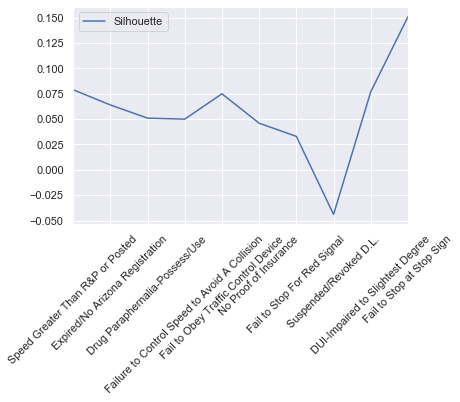

In [79]:
pd.DataFrame(data= {'Silhouette': sil_score},
            index=list(df.charge_description.unique())).plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
plt.xticks(rotation=45);

## DBSCAN

In [80]:
sil_score = []
cluster_count = []

for citation in list(df.charge_description.unique()):
    
    df2 = df[df.charge_description == citation]
    X = pd.get_dummies(df2.drop(['charge_description'], axis=1))
    
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)
    
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=1)

    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    sil_score.append(round(metrics.silhouette_score(X_std, clusters, metric='euclidean'), 3))
    cluster_count.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
sil_score

[0.052, 0.151, 0.222, 0.136, 0.206, 0.151, 0.092, 0.162, 0.206, 0.152]

In [82]:
cluster_count

[1805, 1362, 947, 808, 541, 867, 344, 1109, 765, 103]

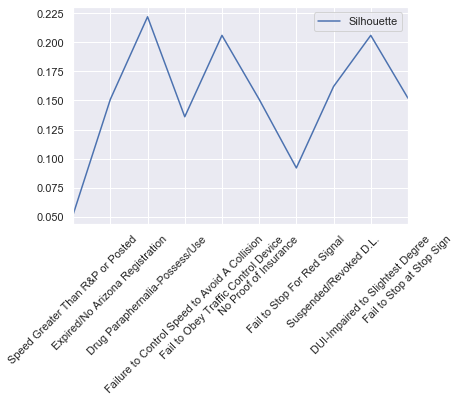

In [87]:
pd.DataFrame(data= {'Silhouette': sil_score},
            index=list(df.charge_description.unique())).plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
plt.xticks(rotation=45);

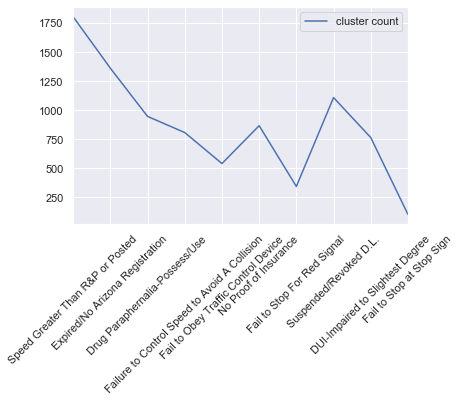

In [88]:
pd.DataFrame(data= {'cluster count': cluster_count},
            index=list(df.charge_description.unique())).plot()

# plt.ylabel('Score Index')
# plt.xlabel('Clusters')
plt.xticks(rotation=45);

## Based on citations that are most clustered above, use pca, t-SNE, and UMAP to visualize clusters

In [66]:
# adjust min_samples parameter

min_samples = []
cluster_count_min_samples = []

for i in range(1,101,10):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=1, min_samples=i)
    min_samples.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_min_samples.append(len(set(clusters)) - (1 if -1 in clusters else 0))
    
cluster_count_min_samples

[103, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [67]:
# adjust eps parameter

eps = []
cluster_count_eps = []

for i in range(1,101,10):
    # Defining the agglomerative clustering
    dbscan_cluster = DBSCAN(eps=i, min_samples=1)
    eps.append(i)
    
    # Fit model
    clusters = dbscan_cluster.fit_predict(X_std)
    cluster_count_eps.append(len(set(clusters)) - (1 if -1 in clusters else 0))
        
cluster_count_eps

[103, 8, 1, 1, 1, 1, 1, 1, 1, 1]

In [68]:
# combine results
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1))

,min_samples,eps
1,103,103
2,0,8
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1
10,0,1


Text(0, 0.5, 'Clusters')

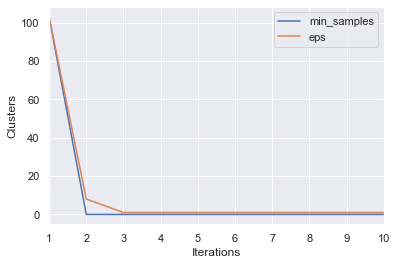

In [69]:
pd.DataFrame(data= {'min_samples': cluster_count_min_samples,
                      'eps': cluster_count_eps},
            index=range(1,11,1)).plot()
plt.xlabel('Iterations')
plt.ylabel('Clusters')